In [ ]:
#pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv("C:/Users/vedan/Downloads/ETERNAL10YR6_1_26 - Sheet1.csv")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)


In [4]:
df["Return"] = df["Close"].pct_change()


In [5]:
df["Ret_lag1"] = df["Return"].shift(1)
df["Ret_lag2"] = df["Return"].shift(2)
df["Ret_lag3"] = df["Return"].shift(3)

df["Ret_ma5"] = df["Return"].rolling(5).mean()
df["Ret_ma10"] = df["Return"].rolling(10).mean()

df = df.dropna().reset_index(drop=True)


In [6]:
features = [
    "Open", "High", "Low", "Volume",
    "Ret_lag1", "Ret_lag2", "Ret_lag3",
    "Ret_ma5", "Ret_ma10"
]

X = df[features]
y = df["Return"]


In [7]:
split = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [8]:
model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
pred_test = model.predict(X_test)
print("MAE (returns):", mean_absolute_error(y_test, pred_test))


MAE (returns): 0.013354933301024755


In [10]:
N_FUTURE_DAYS = 30

future_returns = []
last_row = df.iloc[-1].copy()

last_price = df["Close"].iloc[-1]

for _ in range(N_FUTURE_DAYS):
    X_future = pd.DataFrame([last_row[features]])
    next_ret = model.predict(X_future)[0]
    future_returns.append(next_ret)

    # Shift features
    last_row["Ret_lag3"] = last_row["Ret_lag2"]
    last_row["Ret_lag2"] = last_row["Ret_lag1"]
    last_row["Ret_lag1"] = next_ret

    last_row["Ret_ma5"] = (last_row["Ret_ma5"] * 4 + next_ret) / 5
    last_row["Ret_ma10"] = (last_row["Ret_ma10"] * 9 + next_ret) / 10


In [11]:
future_prices = []
price = last_price

for r in future_returns:
    price = price * (1 + r)
    future_prices.append(price)


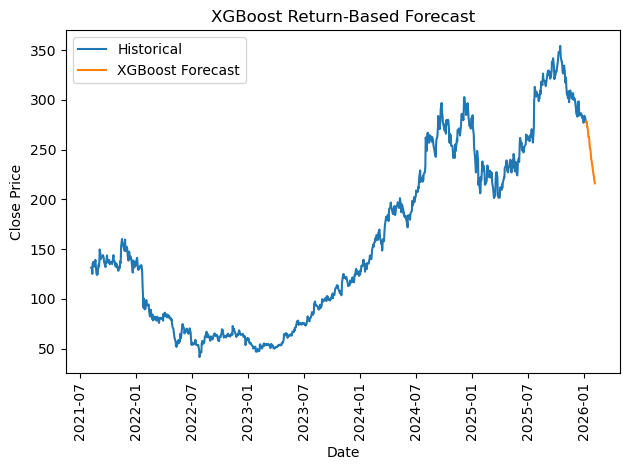

In [12]:
future_dates = pd.date_range(
    start=df["Date"].iloc[-1],
    periods=N_FUTURE_DAYS + 1,
    freq="D"
)[1:]

plt.figure()
plt.plot(df["Date"], df["Close"], label="Historical")
plt.plot(future_dates, future_prices, label="XGBoost Forecast")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("XGBoost Return-Based Forecast")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
final_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Return": future_returns,
    "Predicted_Close": future_prices
})
final_df

,Date,Predicted_Return,Predicted_Close
0,2026-01-07 15:30:00,-0.003478,278.079486
1,2026-01-08 15:30:00,0.002117,278.668084
2,2026-01-09 15:30:00,-0.004795,277.331739
3,2026-01-10 15:30:00,0.001019,277.614238
4,2026-01-11 15:30:00,-0.016488,273.037013
5,2026-01-12 15:30:00,-0.000068,273.018467
6,2026-01-13 15:30:00,-0.010429,270.171178
7,2026-01-14 15:30:00,-0.007336,268.189162
8,2026-01-15 15:30:00,-0.020512,262.688104
9,2026-01-16 15:30:00,0.000435,262.802298


In [15]:
model.save_model("prediction_xgboost_model.json")